# MMSegmentation Tutorial
Welcome to MMSegmentation! 

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results. 

## Install MMSegmentation
This step may take several minutes. 

We use PyTorch 1.10 and CUDA 11.1 for this tutorial. You may install other versions by change the version number in pip install command. 

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

In [ ]:
# Install PyTorch
!pip install torch==1.12.0 torchvision --extra-index-url https://download.pytorch.org/whl/cu113
# Install MMCV
!pip install openmim
!mim install mmcv-full==1.6.0

In [ ]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.12.0+cu113 True
0.30.0


## Run Inference with MMSeg trained weight

In [ ]:
#download pre-trained pspnet wieght
!mkdir checkpoints
!wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth -P checkpoints

In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [ ]:
config_file = 'configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py'
checkpoint_file = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

## Train a semantic segmentation model on a new dataset

To train on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure. 

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data) for details about dataset reorganization. 

We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [ ]:
data_root = '/content/drive/MyDrive/transport_segmentation'
img_dir = 'images'
ann_dir = 'labels_rgb'

## Build custom dataset

Get the classes and rgb color information from the annotation 

In [ ]:
import json

# Open the JSON file for reading
with open('/content/drive/MyDrive/transport_segmentation/ts-color-list.json', 'r') as f:
    # Load the contents of the file into a Python list
    labels = json.loads(f.read())

# Use the data as needed
print(labels)


[{'attribute': '電車', 'color': 'rgb(128,0,0)', 'colorList': [128, 0, 0, 255], 'trainIds': 1}, {'attribute': 'dc9', 'color': 'rgb(0,128,0)', 'colorList': [0, 128, 0, 255], 'trainIds': 2}, {'attribute': '巴膠', 'color': 'rgb(128,128,0)', 'colorList': [128, 128, 0, 255], 'trainIds': 3}]


In [ ]:
classes = tuple(map(lambda x: x['attribute'], labels))
# get rgb color
palette = list(map(lambda x: x['colorList'][0:3], labels)) 
# add classes for background, so every pixel will get segmentation when possible
classes=('bg',)+classes
palette = [[0,0,0]]+ palette

Convert the segment image into 

In [ ]:
import os
from PIL import Image
import numpy as np

# Define the input and output directories
input_dir = "/content/drive/MyDrive/transport_segmentation/labels_rgb"
output_dir = "/content/drive/MyDrive/transport_segmentation/labels"

# Loop through all files in the input directory
for filename in os.listdir(input_dir):
    # Check if the file is a PNG image
    if filename.endswith("jpg_segmentation.png"):
        # Open the CMYK image
        img = Image.open(os.path.join(input_dir, filename)).convert("P")
        # Convert the image to RGB format
        img = img.convert('RGB')
        # Get the size of the image
        width, height = img.size
        # Create an empty matrix to store the color values
        matrix = []
        # Loop through each pixel in the image and convert it to a value based on its color
        for y in range(height):
            row = []
            for x in range(width):
                r, g, b = img.getpixel((x, y))
                if (r, g, b) == (128, 0, 0):
                    row.append(1)
                elif (r, g, b) == (0, 128, 0):
                    row.append(2)
                elif (r, g, b) == (128, 128, 0):
                    row.append(3)
                else:
                    row.append(0)
            matrix.append(row)
        # Save the matrix to a text file
        with open(os.path.join(output_dir, filename.replace('.jpg_segmentation.png', 
                                                         '.txt')), 'w') as f:
            for row in matrix:
                f.write(' '.join(str(x) for x in row) + '\n')

In [ ]:
import os.path as osp
import numpy as np
import mmcv
from PIL import Image
# Define the input and output directories
input_dir = "/content/drive/MyDrive/transport_segmentation/labels"
output_dir = "/content/drive/MyDrive/transport_segmentation/labels"

for file in mmcv.scandir(input_dir, suffix='.txt'):
  seg_map = np.loadtxt(osp.join(input_dir, file)).astype(np.uint8)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8)) 
  seg_img.save(osp.join(output_dir, file.replace('.txt', '.png')))

In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class StanfordBackgroundDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette 
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [ ]:
# Install tree first
#!apt-get -q install tree
#!tree /content/drive/MyDrive/transport_segmentation

In [ ]:
import mmcv
import os.path as osp
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
#filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
#    osp.join(data_root, ann_dir), suffix='.jpeg_segmentation.png')]
filename_list = [osp.splitext(filename)[0].split('.jpg')[0] for filename in mmcv.scandir(
    osp.join(data_root, img_dir), suffix='.jpg')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [ ]:
data_root = '/content/drive/MyDrive/transport_segmentation'
img_dir = 'images'
ann_dir = 'labels'

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38651 (\N{CJK UNIFIED IDEOGRAPH-96FB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36554 (\N{CJK UNIFIED IDEOGRAPH-8ECA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24052 (\N{CJK UNIFIED IDEOGRAPH-5DF4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33184 (\N{CJK UNIFIED IDEOGRAPH-81A0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


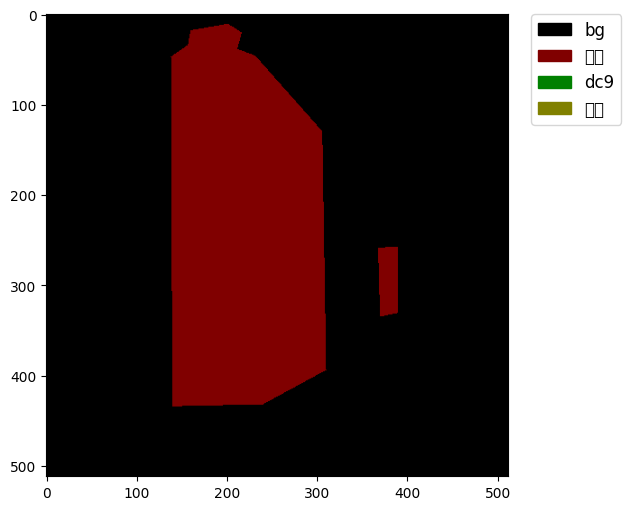

In [ ]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
img = Image.open('/content/drive/MyDrive/transport_segmentation/labels/4.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(len(classes))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [ ]:
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

In [ ]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device
import os.path as osp
import numpy as np
from PIL import Image

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = len(classes)
cfg.model.auxiliary_head.num_classes = len(classes)

# Modify dataset type and path
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 2
cfg.data.workers_per_gpu = 2

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
    ]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 1
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=4,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=F

### Train and Evaluation

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor
import mmcv
import os.path as osp

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

2023-04-03 13:19:00,524 - mmseg - INFO - Loaded 25 images
/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


In [ ]:
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2023-04-03 13:19:03,828 - mmseg - INFO - Loaded 7 images
2023-04-03 13:19:03,835 - mmseg - INFO - load checkpoint from local path: checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
2023-04-03 13:19:04,088 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([4, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([4, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([4]).
2023-04-03 13:19:04,109 - 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 7/7, 4.5 task/s, elapsed: 2s, ETA:     0s

2023-04-03 13:20:21,722 - mmseg - INFO - per class results:
2023-04-03 13:20:21,724 - mmseg - INFO - 
+-------+-------+-------+
| Class |  IoU  |  Acc  |
+-------+-------+-------+
|   bg  | 83.99 | 93.76 |
|  電車 | 46.51 | 70.91 |
|  dc9  | 61.28 | 97.21 |
|  巴膠 |  60.4 | 60.86 |
+-------+-------+-------+
2023-04-03 13:20:21,726 - mmseg - INFO - Summary:
2023-04-03 13:20:21,727 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 84.29 | 63.04 | 80.68 |
+-------+-------+-------+
2023-04-03 13:20:21,730 - mmseg - INFO - Iter(val) [7]	aAcc: 0.8429, mIoU: 0.6304, mAcc: 0.8068, IoU.bg: 0.8399, IoU.電車: 0.4651, IoU.dc9: 0.6128, IoU.巴膠: 0.6040, Acc.bg: 0.9376, Acc.電車: 0.7091, Acc.dc9: 0.9721, Acc.巴膠: 0.6086


Inference with trained model

/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 800x600 with 0 Axes>

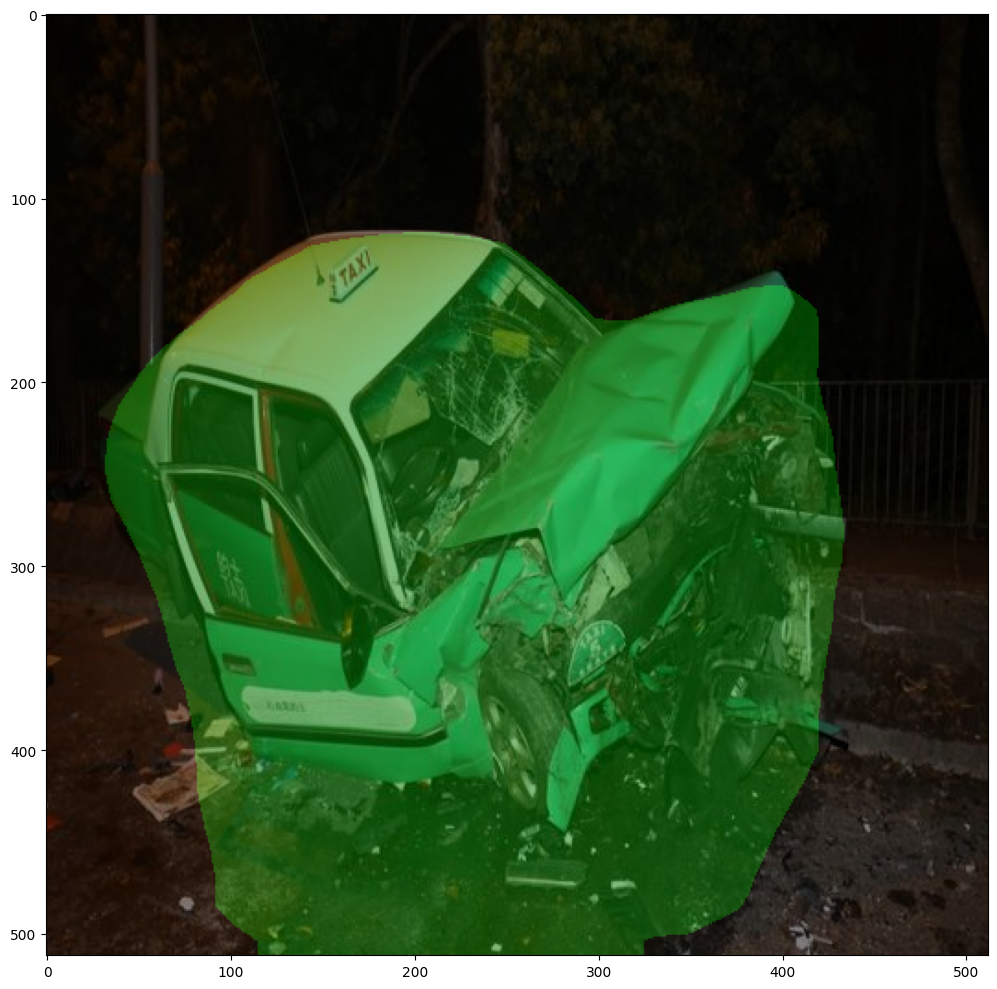

In [ ]:
img = mmcv.imread('/content/drive/MyDrive/transport_segmentation/images/14.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)